# Probabilistic Time Series Forecasting with 🤗 Transformers
- https://huggingface.co/blog/time-series-transformers

---

아래의 코드는 위의 트랜스포머 기반의 코드를 세이지 메이커 노트북 인스턴스에서 동작 여부를 확인하기 위해서 싫행 했습니다.
아래 셀 실행의 결과를 확인하시면 됩니다.

In [2]:
!pip install -q transformers==4.26.1

!pip install -q datasets

!pip install -q evaluate

!pip install -q accelerate

!pip install  -q gluonts ujson


In [40]:
%%sh 
pip list | grep transformers
pip list | grep torch
pip list | grep datasets
pip list | grep evaluate
pip list | grep accelerate
pip list | grep gluonts
pip list | grep ujson

transformers                       4.26.1
pytorch-forecasting                0.10.3
pytorch-lightning                  1.9.3
torch                              1.12.1
torchmetrics                       0.11.3
torchvision                        0.10.1
datasets                           2.4.0
evaluate                           0.4.0
accelerate                         0.12.0
gluonts                            0.12.3
ujson                              4.2.0


In [3]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")


Reusing dataset monash_tsf (/home/ec2-user/.cache/huggingface/datasets/monash_tsf/tourism_monthly/1.0.0/82998723d55d6edbc664cfaebe371004d849846ee5f61b57f1f974000d44c050)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset



DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [5]:
train_example = dataset['train'][0]
train_example.keys()




dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [6]:
print(train_example['start'])
print(train_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [7]:
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [8]:
print(validation_example['start'])
print(validation_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [9]:
freq = "1M"
prediction_length = 24

assert len(train_example['target']) + prediction_length == len(validation_example['target'])

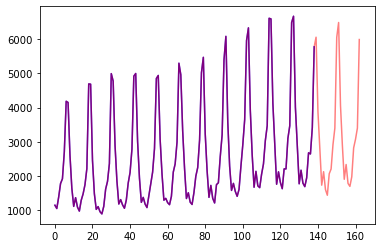

In [10]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example['target'], color="blue") 
axes.plot(validation_example['target'], color="red", alpha=0.5)

plt.show()


In [11]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]


In [12]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [13]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))


In [14]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)



[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [15]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)




[<function month_of_year at 0x7f1d0805f5e0>]


In [16]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=prediction_length*3, # context length
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1, # we'll add 2 time features ("month of year" and "age", see further)
    num_static_categorical_features=1, # we have a single static categorical feature, namely time series ID
    cardinality=[len(train_dataset)], # it has 366 possible values
    embedding_dimension=[2], # the model will learn an embedding of size 2 for each of the 366 possible values
    encoder_layers=4, 
    decoder_layers=4,
)

model = TimeSeriesTransformerForPrediction(config)


In [19]:
model.config.distribution_output




'student_t'

In [20]:
from gluonts.time_feature import time_features_from_frequency_str, TimeFeature, get_lags_for_frequency
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)


In [21]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: use static features if available, if not add dummy values
        + (
            [SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0])]
            if not config.num_static_categorical_features > 0
            else []
        )
        + (
            [SetField(output_field=FieldName.FEAT_STATIC_REAL, value=[0.0])]
            if not config.num_static_real_features > 0
            else []
        )
        # step 3: convert the data to NumPy (potentially not needed)
        + [
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_CAT,
                expected_ndim=1,
                dtype=int,
            ),
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_REAL,
                expected_ndim=1,
            ),
            AsNumpyArray(
                field=FieldName.TARGET,
                # in the following line, we add 1 for the time dimension
                expected_ndim=1 if config.input_size==1 else 2,
            ),
            # step 4: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 5: add temporal features based on freq of the dataset
            # month of year in this case
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 6: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 7: vertically stack all the temporal features
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + ([FieldName.FEAT_DYNAMIC_REAL] if config.num_dynamic_real_features > 0 else []),
            ),
            # step 8: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [22]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(config: PretrainedConfig, mode: str, train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation":  validation_sampler or ValidationSplitSampler(
            min_future=config.prediction_length
        ),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=[
            "time_features",
            "observed_mask",
        ],
    )


In [23]:
from gluonts.itertools import Cyclic, IterableSlice, PseudoShuffled
from gluonts.torch.util import IterableDataset
from torch.utils.data import DataLoader

from typing import Iterable

def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "static_categorical_features",
        "static_real_features",
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
        ]

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
        ]
    
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    
    # we initialize a Training instance
    instance_splitter = create_instance_splitter(
        config, "train"
    ) + SelectFields(TRAINING_INPUT_NAMES)


    # the instance splitter will sample a window of 
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    training_instances = instance_splitter.apply(
        Cyclic(transformed_data)
        if shuffle_buffer_length is None
        else PseudoShuffled(
            Cyclic(transformed_data), 
            shuffle_buffer_length=shuffle_buffer_length,
        )
    )

    # from the training instances iterator we now return a Dataloader which will 
    # continue to sample random windows for as long as it is called
    # to return batch_size of the appropriate tensors ready for training!
    return IterableSlice(
        iter(
            DataLoader(
                IterableDataset(training_instances),
                batch_size=batch_size,
                **kwargs,
            )
        ),
        num_batches_per_epoch,
    )


In [24]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "static_categorical_features",
        "static_real_features",
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
        ]
    
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)
    
    # we create a Test Instance splitter which will sample the very last 
    # context window seen during training only for the encoder.
    instance_splitter = create_instance_splitter(
        config, "test"
    ) + SelectFields(PREDICTION_INPUT_NAMES)
    
    # we apply the transformations in test mode
    testing_instances = instance_splitter.apply(transformed_data, is_train=False)
    
    # This returns a Dataloader which will go over the dataset once.
    return DataLoader(IterableDataset(testing_instances), batch_size=batch_size, **kwargs)


In [25]:
train_dataloader = create_train_dataloader(
    config=config, 
    freq=freq, 
    data=train_dataset, 
    batch_size=256, 
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config, 
    freq=freq, 
    data=test_dataset,
    batch_size=64,
)


In [27]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape, v.type())


static_categorical_features torch.Size([256, 1]) torch.LongTensor
static_real_features torch.Size([256, 1]) torch.FloatTensor
past_time_features torch.Size([256, 109, 2]) torch.FloatTensor
past_values torch.Size([256, 109]) torch.FloatTensor
past_observed_mask torch.Size([256, 109]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


In [28]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True
)


In [29]:
print("Loss:", outputs.loss.item())

Loss: 9.291537284851074


# 훈련 코드
- 약 V100 1장으로 약 20분 소요됨.

In [30]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
 
model, optimizer, train_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, 
)

for epoch in range(40):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device),
            static_real_features=batch["static_real_features"].to(device),
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        print(loss.item())


8.849108695983887
8.673515319824219
8.74687671661377
9.398648262023926
8.562169075012207
8.103873252868652
9.250666618347168
8.981152534484863
8.260499954223633
8.973776817321777
8.720635414123535
8.08687686920166
8.457777976989746
8.676192283630371
8.288634300231934
8.180805206298828
8.661636352539062
8.632525444030762
8.336769104003906
7.977322101593018
8.887077331542969
8.099394798278809
7.865170955657959
8.460963249206543
8.580962181091309
8.058728218078613
8.075606346130371
8.753826141357422
8.093791961669922
7.7569427490234375
8.454951286315918
8.354931831359863
7.876551151275635
7.9286322593688965
8.509577751159668
8.130179405212402
7.7941670417785645
8.433833122253418
8.237272262573242
7.706714153289795
8.149906158447266
8.385261535644531
8.021771430969238
7.681354522705078
8.33481502532959
8.19873332977295
7.680148601531982
8.16223430633545
8.425408363342285
7.444433212280273
8.3576021194458
7.966930389404297
7.977181911468506
7.718209743499756
8.239581108093262
8.101883888244

In [31]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device),
        static_real_features=batch["static_real_features"].to(device),
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())


In [32]:
forecasts[0].shape



(64, 100, 24)

In [33]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


In [34]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])


In [35]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.5565443020630831


In [36]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.1864608410496753


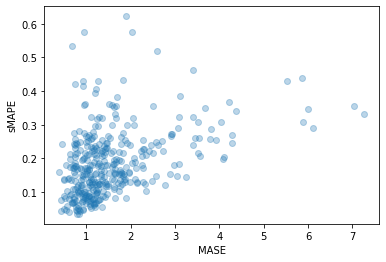

In [37]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()


In [38]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()


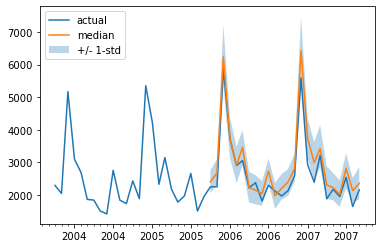

In [39]:
plot(334)